# 7章 RによるARIMAモデル

In [1]:
# パッケージの読み込み
library(forecast)
library(tseries)
library(ggplot2)
library(ggfortify)
library(repr)

# グラフのオプション
options(repr.plot.width=14, repr.plot.height=6)

Warning message:
"package 'forecast' was built under R version 4.0.2"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"package 'ggplot2' was built under R version 4.0.2"
Warning message:
"package 'ggfortify' was built under R version 4.0.2"
Registered S3 methods overwritten by 'ggfortify':
  method                 from    
  autoplot.Arima         forecast
  autoplot.acf           forecast
  autoplot.ar            forecast
  autoplot.bats          forecast
  autoplot.decomposed.ts forecast
  autoplot.ets           forecast
  autoplot.forecast      forecast
  autoplot.stl           forecast
  autoplot.ts            forecast
  fitted.ar              forecast
  fortify.ts             forecast
  residuals.ar           forecast



## 分析の対象
イギリスの交通事故死傷者数のデータSeatbeltsを使用する。
- front: 前席における死傷者数
- PetrolPrice: ガソリンの値段
- law: 前席においてシートベルトを装着することを義務付けた法律の施行の有無を表したフラグ。0だと未施工。1だと試行済み。1983年の1月31日に施工された。

In [2]:
head(Seatbelts[,])

,DriversKilled,drivers,front,rear,kms,PetrolPrice,VanKilled,law
Jan 1969,107,1687,867,269,9059,0.1029718,12,0
Feb 1969,97,1508,825,265,7685,0.1023630,6,0
Mar 1969,102,1507,806,319,9963,0.1020625,12,0
Apr 1969,87,1385,814,407,10955,0.1008733,8,0
May 1969,119,1632,991,454,11823,0.1010197,10,0
Jun 1969,106,1511,945,427,12391,0.1005812,13,0


In [5]:
front <- Seatbelts[, "front"]

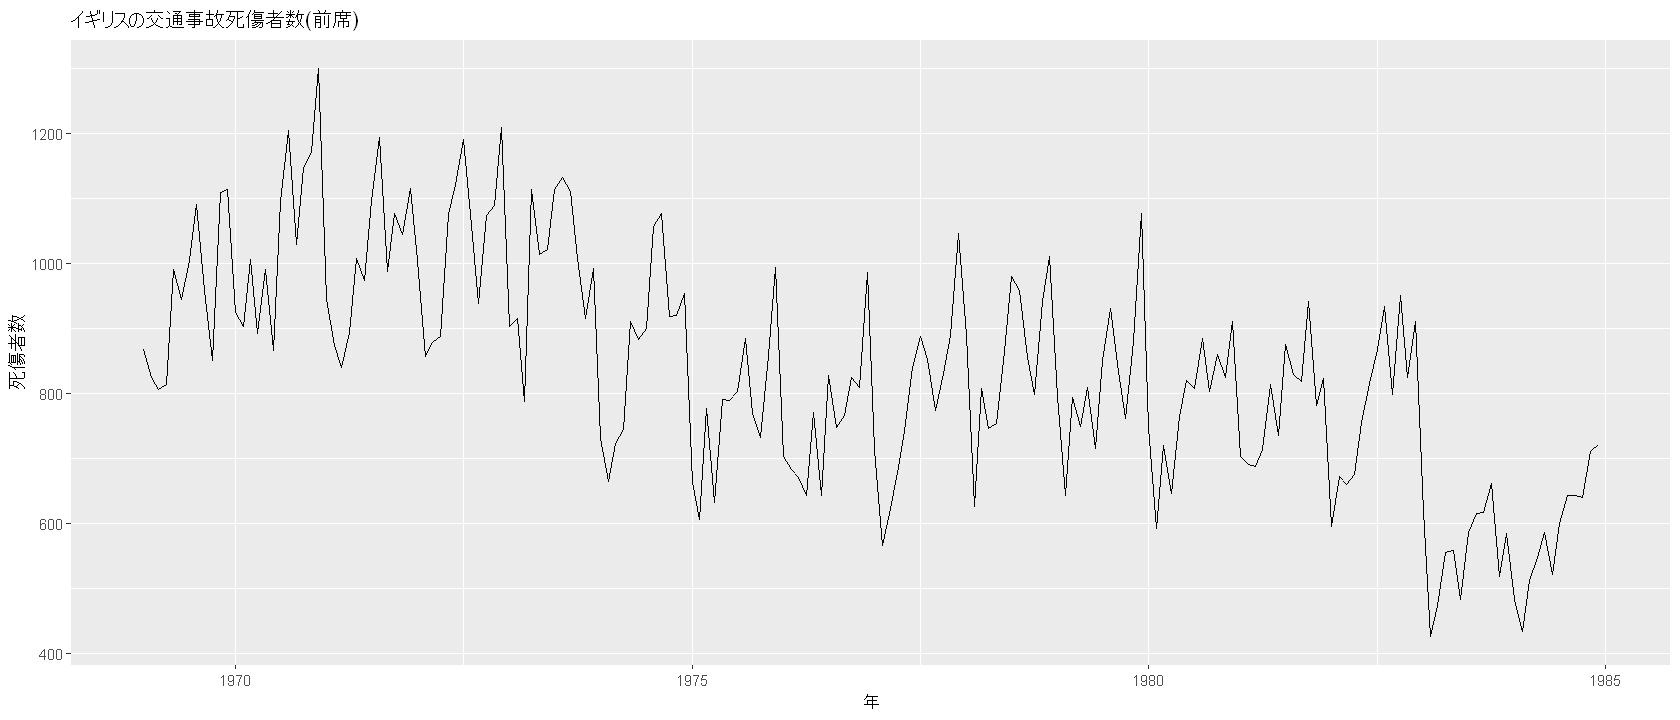

In [6]:
# グラフ描写
autoplot(
    Seatbelts[, "front"],
    main="イギリスの交通事故死傷者数(前席)",
    xlab="年",
    ylab="死傷者数"
)

In [7]:
front

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1969,867,825,806,814,991,945,1004,1091,958,850,1109,1113
1970,925,903,1006,892,990,866,1095,1204,1029,1147,1171,1299
1971,944,874,840,893,1007,973,1097,1194,988,1077,1045,1115
1972,1005,857,879,887,1075,1121,1190,1058,939,1074,1089,1208
1973,903,916,787,1114,1014,1022,1114,1132,1111,1008,916,992
1974,731,665,724,744,910,883,900,1057,1076,919,920,953
1975,664,607,777,633,791,790,803,884,769,732,859,994
1976,704,684,671,643,771,644,828,748,767,825,810,986
1977,714,567,616,678,742,840,888,852,774,831,889,1046
1978,889,626,808,746,754,865,980,959,856,798,942,1010


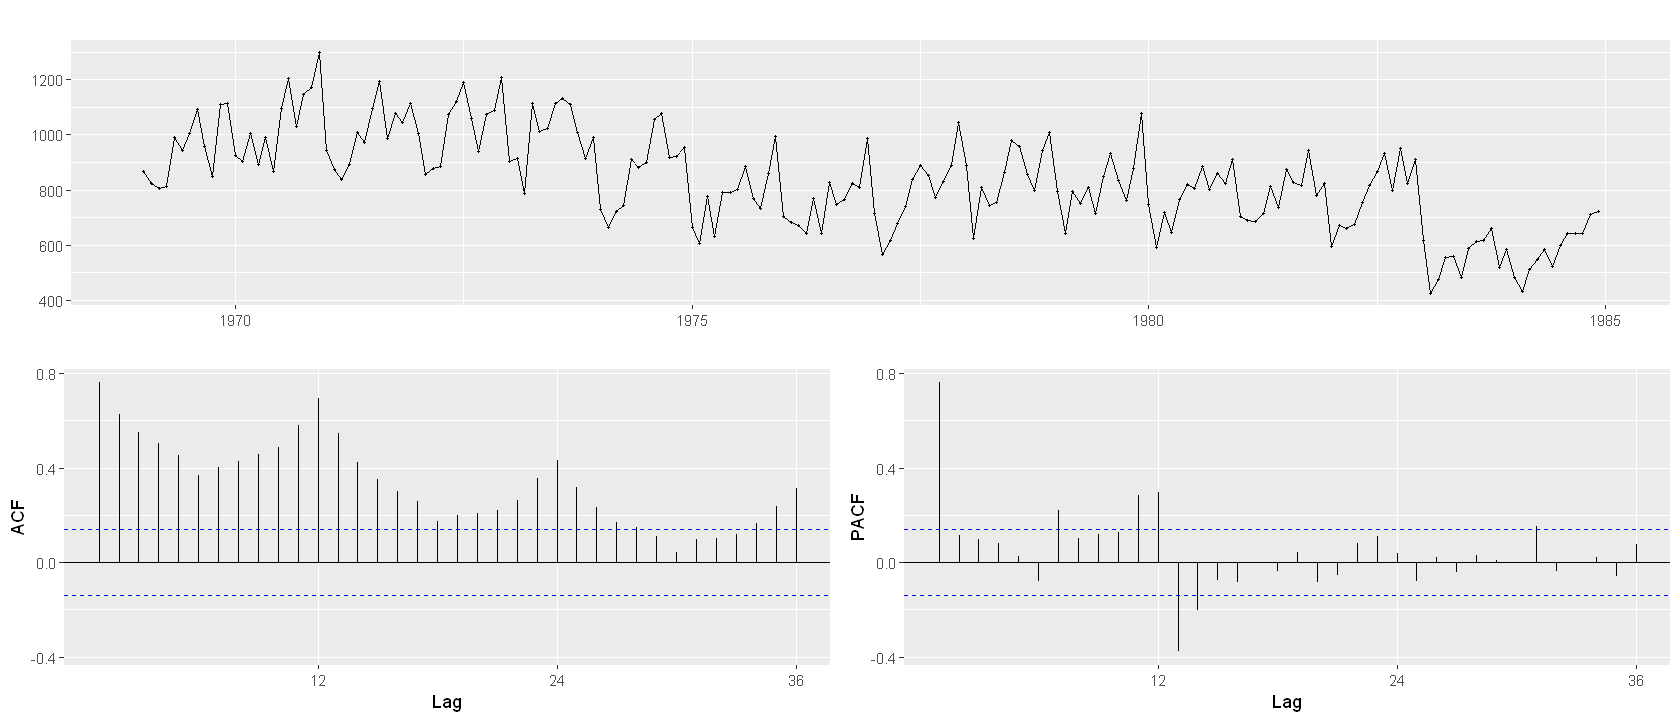

In [11]:
ggtsdisplay(front)

- 毎年12月に死傷者数が増えているのでこの周期をモデルに組込む
- シートベルト法案について死傷者数を減らす効果があるはず

季節成分と外生変数の入ったARIMAモデル、すなわち**SARIMAX**を使って時系列モデルを構築する

## 対数変換

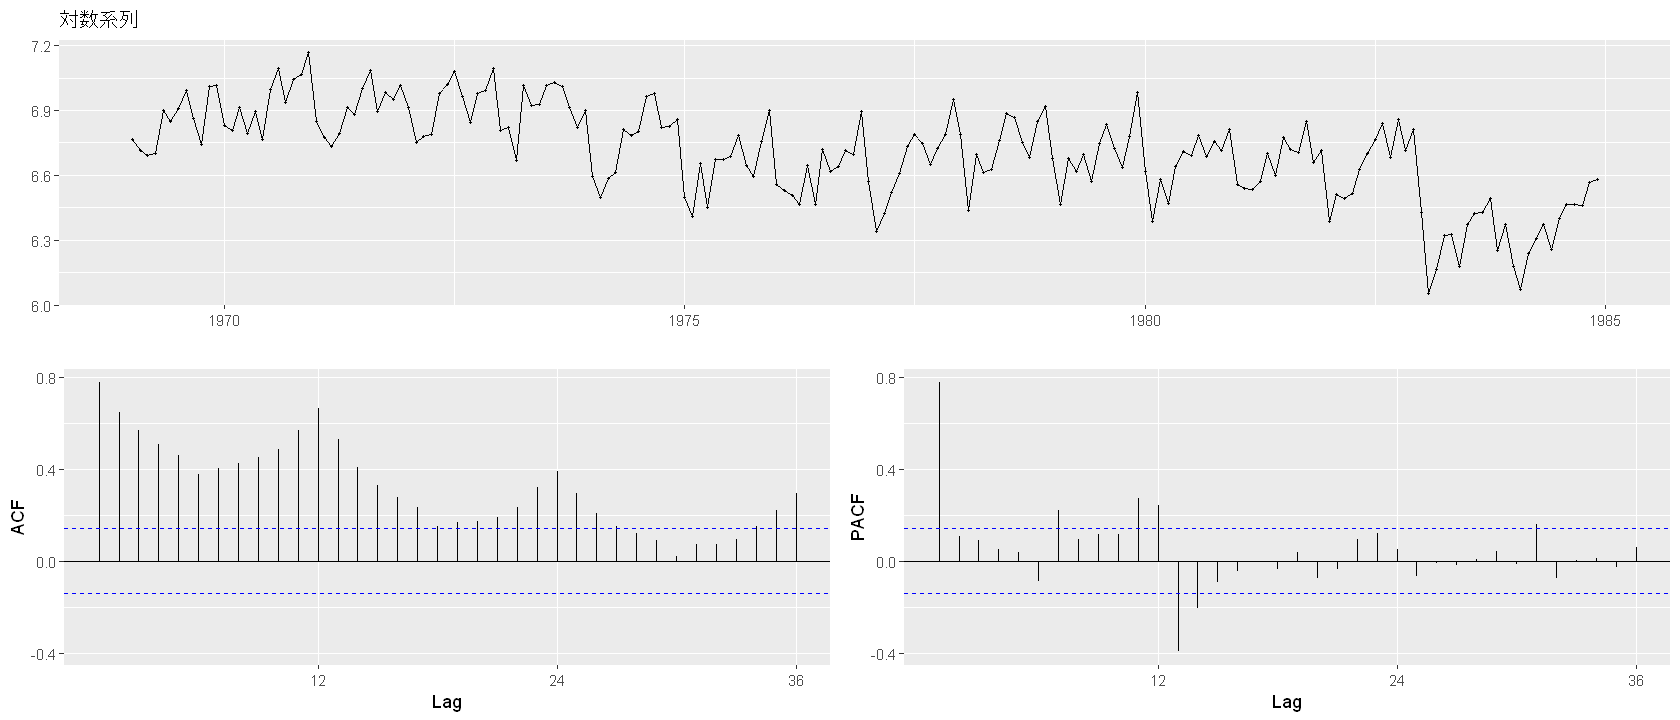

In [10]:
# 対数系列
log_front <- log(front)

# 図示
# ACFは相関係数
# PACFは偏相関係数
ggtsdisplay(log_front, main="対数系列")

- 対数変換をすることで、年毎の変動の幅がおよそ均一になった。
- 長期にわたって自己相関が続いている
- 12か月周期で自己相関が大きくなっている
- およそ1年谷で大きな偏自己相関がみられる

## 差分系列の作成方法

In [12]:
# ラグを取ってずらす
# 原系列
front

# ラグをとったもの
# 時点を一つ未来にずらす
lag(front, -1)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1969,867,825,806,814,991,945,1004,1091,958,850,1109,1113
1970,925,903,1006,892,990,866,1095,1204,1029,1147,1171,1299
1971,944,874,840,893,1007,973,1097,1194,988,1077,1045,1115
1972,1005,857,879,887,1075,1121,1190,1058,939,1074,1089,1208
1973,903,916,787,1114,1014,1022,1114,1132,1111,1008,916,992
1974,731,665,724,744,910,883,900,1057,1076,919,920,953
1975,664,607,777,633,791,790,803,884,769,732,859,994
1976,704,684,671,643,771,644,828,748,767,825,810,986
1977,714,567,616,678,742,840,888,852,774,831,889,1046
1978,889,626,808,746,754,865,980,959,856,798,942,1010


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1969,,867,825,806,814,991,945,1004,1091,958,850,1109
1970,1113,925,903,1006,892,990,866,1095,1204,1029,1147,1171
1971,1299,944,874,840,893,1007,973,1097,1194,988,1077,1045
1972,1115,1005,857,879,887,1075,1121,1190,1058,939,1074,1089
1973,1208,903,916,787,1114,1014,1022,1114,1132,1111,1008,916
1974,992,731,665,724,744,910,883,900,1057,1076,919,920
1975,953,664,607,777,633,791,790,803,884,769,732,859
1976,994,704,684,671,643,771,644,828,748,767,825,810
1977,986,714,567,616,678,742,840,888,852,774,831,889
1978,1046,889,626,808,746,754,865,980,959,856,798,942


In [13]:
# 原系列からラグをとったデータを引けば差分系列がとれる
front - lag(front, -1)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1969,,-42,-19,8,177,-46,59,87,-133,-108,259,4
1970,-188,-22,103,-114,98,-124,229,109,-175,118,24,128
1971,-355,-70,-34,53,114,-34,124,97,-206,89,-32,70
1972,-110,-148,22,8,188,46,69,-132,-119,135,15,119
1973,-305,13,-129,327,-100,8,92,18,-21,-103,-92,76
1974,-261,-66,59,20,166,-27,17,157,19,-157,1,33
1975,-289,-57,170,-144,158,-1,13,81,-115,-37,127,135
1976,-290,-20,-13,-28,128,-127,184,-80,19,58,-15,176
1977,-272,-147,49,62,64,98,48,-36,-78,57,58,157
1978,-157,-263,182,-62,8,111,115,-21,-103,-58,144,68


In [14]:
# もっと簡単にdiff関数を使う
diff(front, lag=1) # default=1

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1969,,-42,-19,8,177,-46,59,87,-133,-108,259,4
1970,-188,-22,103,-114,98,-124,229,109,-175,118,24,128
1971,-355,-70,-34,53,114,-34,124,97,-206,89,-32,70
1972,-110,-148,22,8,188,46,69,-132,-119,135,15,119
1973,-305,13,-129,327,-100,8,92,18,-21,-103,-92,76
1974,-261,-66,59,20,166,-27,17,157,19,-157,1,33
1975,-289,-57,170,-144,158,-1,13,81,-115,-37,127,135
1976,-290,-20,-13,-28,128,-127,184,-80,19,58,-15,176
1977,-272,-147,49,62,64,98,48,-36,-78,57,58,157
1978,-157,-263,182,-62,8,111,115,-21,-103,-58,144,68


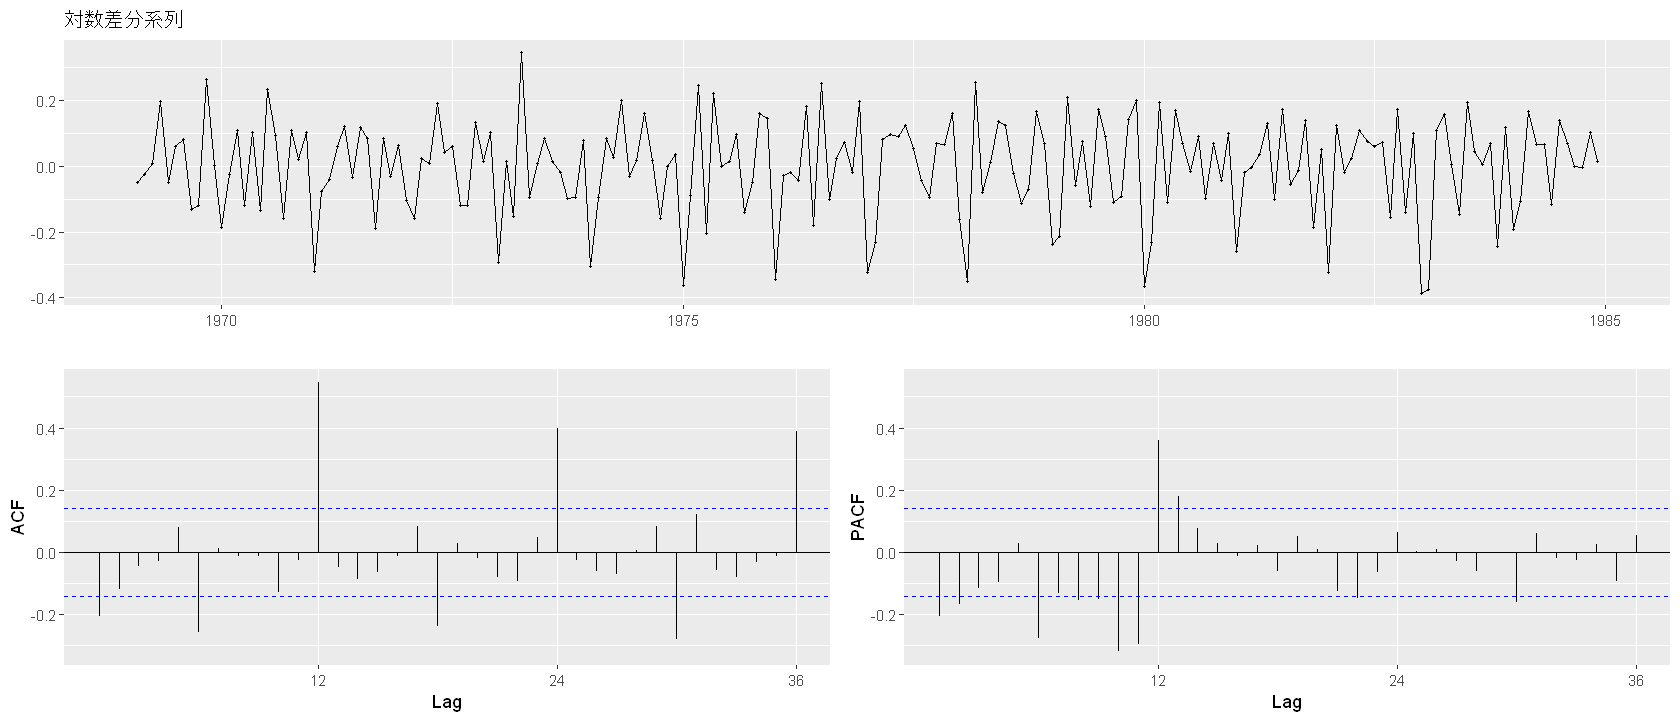

In [15]:
# 対数差分系列が欲しい
log_diff <- diff(log_front, lag=1)

# 図示
ggtsdisplay(log_diff, main="対数差分系列")

- 平均値が変化せず、定常過程っぽい波形になっているので単位根がなくなっていると見なせる
- 短期の自己相関は減ったが、不規則に絶対値の大きな自己相関がみられる
- 1年単位での自己相関も目立つ

## 季節成分の取り扱い  

1年単位での自己相関がある⇒季節成分があるとみなせる   
月ごとに分けたグラフを書いてみる。

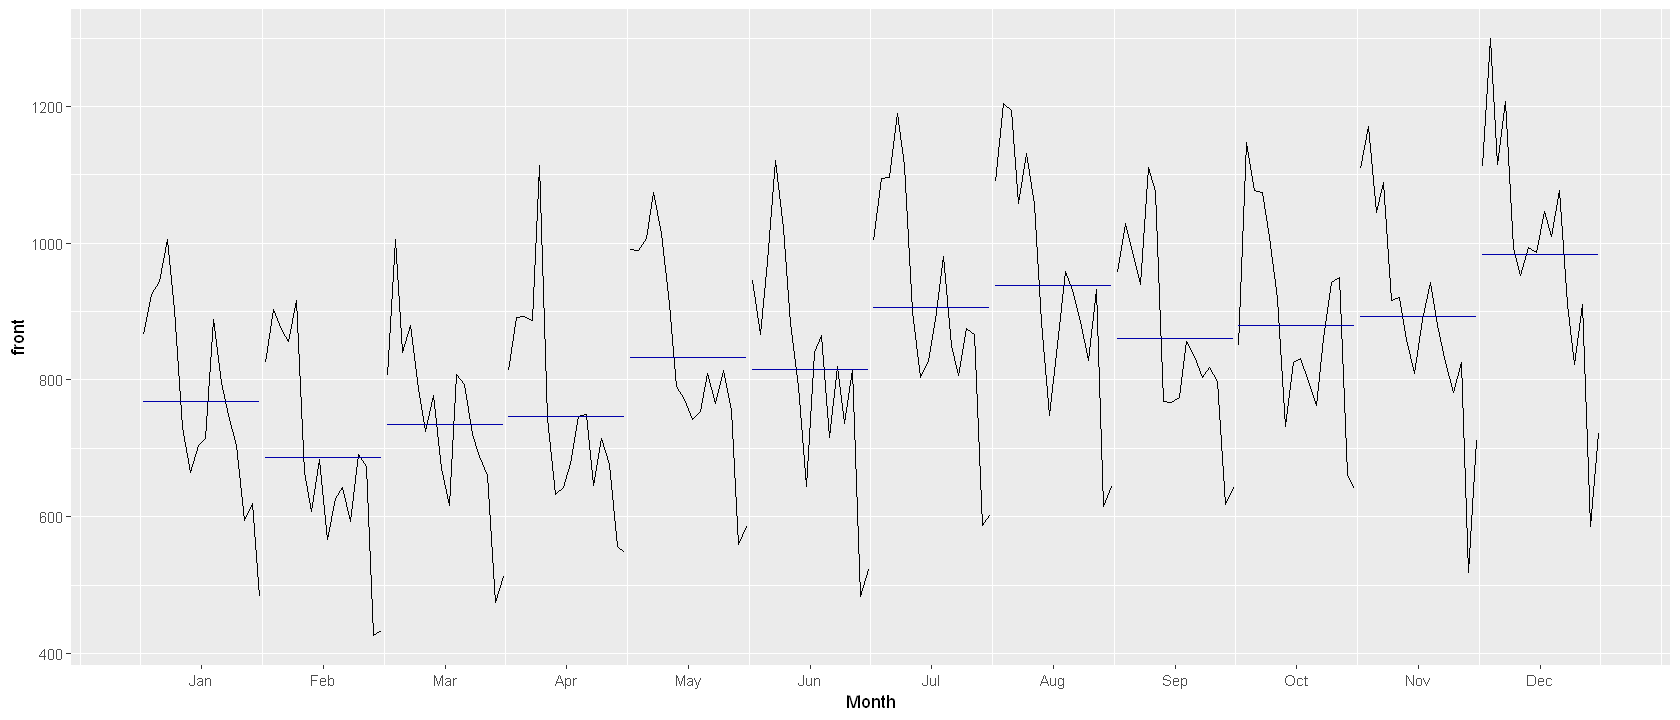

In [16]:
ggsubseriesplot(front)

In [18]:
# 季節差分を取ってみる
frequency(front)

diff(front, lag=frequency(front))

[1] 12

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1970,58,78,200,78,-1,-79,91,113,71,297,62,186
1971,19,-29,-166,1,17,107,2,-10,-41,-70,-126,-184
1972,61,-17,39,-6,68,148,93,-136,-49,-3,44,93
1973,-102,59,-92,227,-61,-99,-76,74,172,-66,-173,-216
1974,-172,-251,-63,-370,-104,-139,-214,-75,-35,-89,4,-39
1975,-67,-58,53,-111,-119,-93,-97,-173,-307,-187,-61,41
1976,40,77,-106,10,-20,-146,25,-136,-2,93,-49,-8
1977,10,-117,-55,35,-29,196,60,104,7,6,79,60
1978,175,59,192,68,12,25,92,107,82,-33,53,-36
1979,-93,17,-14,4,55,-149,-129,-28,-22,-36,-62,67


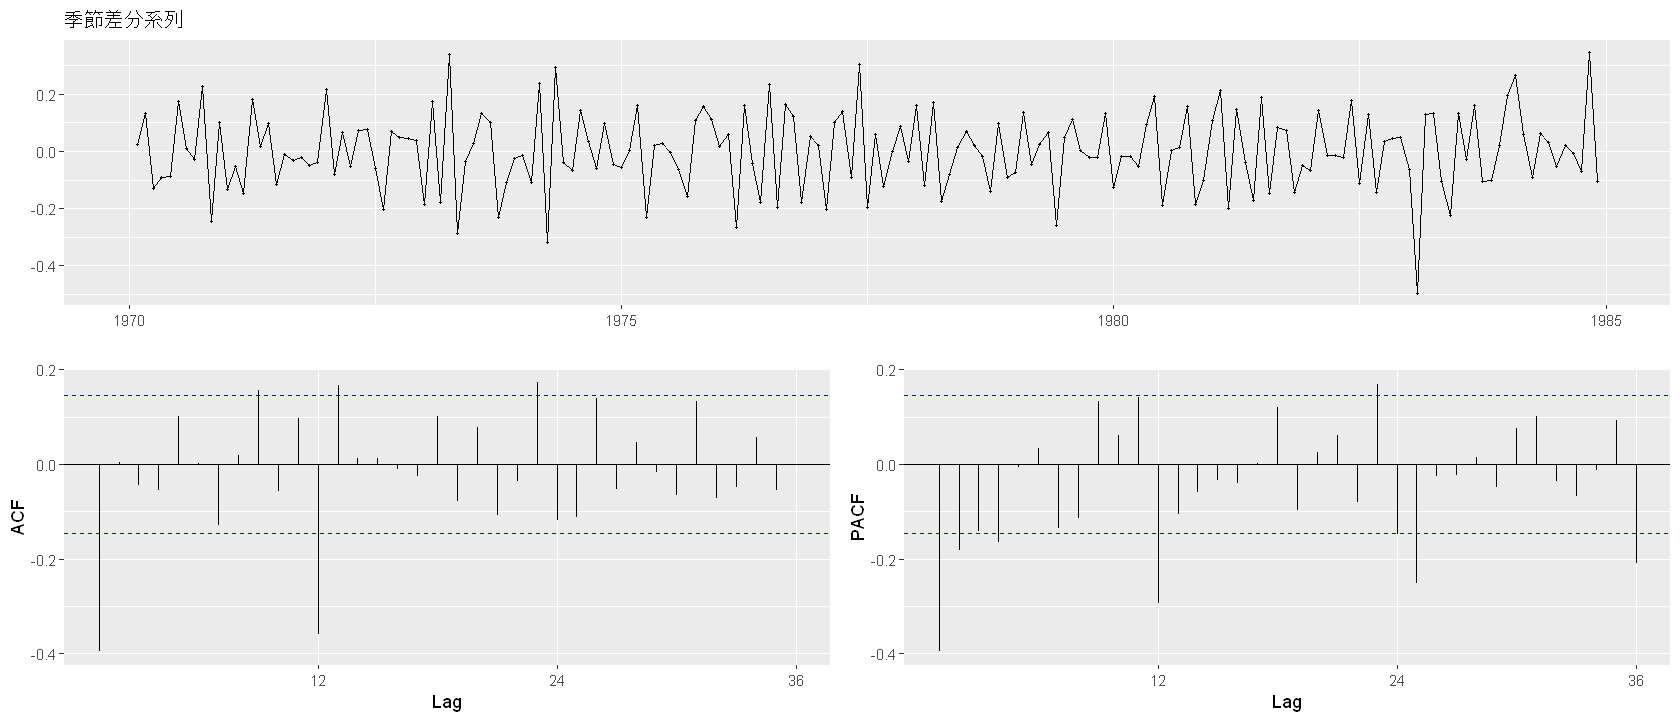

In [20]:
# 対数差分系列にさらに季節差分をとる
seas_log_diff <- diff(log_diff, lag=frequency(log_diff))

# 図示
ggtsdisplay(seas_log_diff, main="季節差分系列")

- 12か月単位の自己相関が大きく残ったままとなった。
- 季節階差をとったからといって、季節の影響をすべて取り除けるわけではないようだ。

## 自己相関とコレログラム

自己相関の値で得たいときはacf関数を使う。acf関数は標準だと勝手にグラフ表示されるので、plot=Fとする。

In [22]:
acf(seas_log_diff, plot=F, lag.max=12)


Autocorrelations of series 'seas_log_diff', by lag

0.0000 0.0833 0.1667 0.2500 0.3333 0.4167 0.5000 0.5833 0.6667 0.7500 0.8333 
 1.000 -0.396  0.004 -0.045 -0.055  0.101  0.002 -0.129  0.020  0.156 -0.056 
0.9167 1.0000 
 0.097 -0.359 

In [23]:
pacf(seas_log_diff, plot=F, lag.max=12)


Partial autocorrelations of series 'seas_log_diff', by lag

0.0833 0.1667 0.2500 0.3333 0.4167 0.5000 0.5833 0.6667 0.7500 0.8333 0.9167 
-0.396 -0.181 -0.141 -0.165 -0.006  0.034 -0.135 -0.114  0.134  0.062  0.142 
1.0000 
-0.293 

Warning message:
"`mutate_()` is deprecated as of dplyr 0.7.0.
Please use `mutate()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


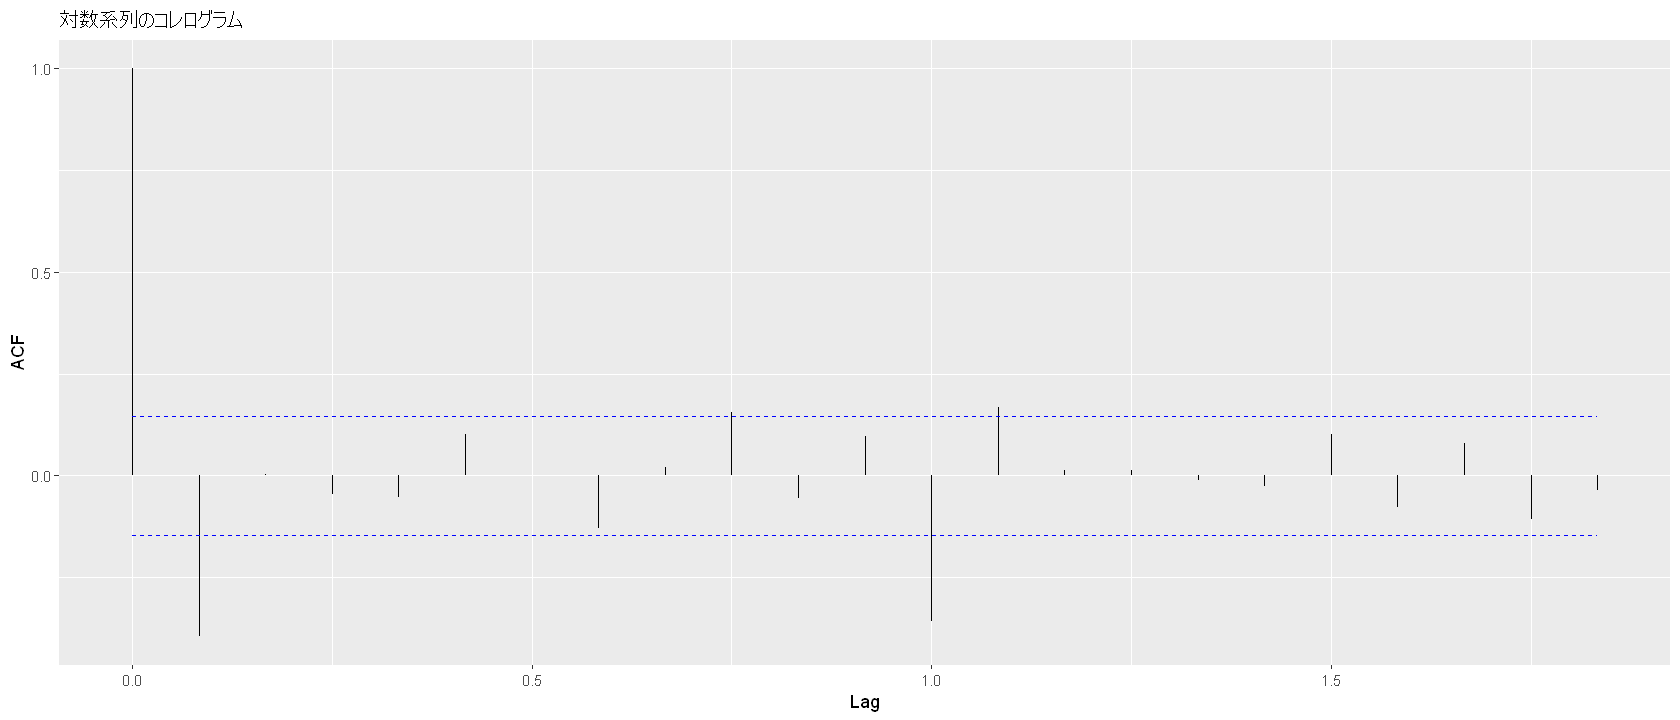

In [24]:
autoplot(
    acf(seas_log_diff, plot=F),
    main="対数系列のコレログラム"
)

## 訓練データとテストデータに分ける

対数変換したデータをつくる。法律の施行は0or1のフラグなので変換しない。

In [26]:
Seatbelts_log <- Seatbelts[, c("front", "PetrolPrice", "law")]
Seatbelts_log[, "front"] <- log(Seatbelts[, "front"])
Seatbelts_log[, "PetrolPrice"] <- log(Seatbelts[, "PetrolPrice"])

In [28]:
# 最後の1年(1984年)をテストデータ、それより前を訓練データとする
train <- window(Seatbelts_log, end=c(1983, 12))
test <- window(Seatbelts_log, start=c(1984, 1))

In [31]:
head(train)

,front,PetrolPrice,law
Jan 1969,6.765039,-2.27330,0
Feb 1969,6.715383,-2.27923,0
Mar 1969,6.692084,-2.28217,0
Apr 1969,6.701960,-2.29389,0
May 1969,6.898715,-2.29244,0
Jun 1969,6.851185,-2.29679,0


In [32]:
# 目的変数はfrontであり、それ以外は説明変数
# 説明変数だけ切り分けておく
petro_law <- train[, c("PetrolPrice", "law")]

## ARIMAモデルの推定
forecastパッケージのarima関数を使う。

- y: 応答変数  
- order: SARIMA(p,d,q)(P,D,Q)の(p,d,q)の次数(暫定)
- seasonal: 季節成分(P,D,Q)
- xreg: 説明変数の指定

In [33]:
model_sarimax <- Arima(
    y = train[, "front"],
    order = c(1, 1, 1),
    seasonal = list(order = c(1, 0, 0)),
    xreg = petro_law
)

In [34]:
model_sarimax

Series: train[, "front"] 
Regression with ARIMA(1,1,1)(1,0,0)[12] errors 

Coefficients:
         ar1      ma1    sar1  PetrolPrice      law
      0.2589  -0.9503  0.6877      -0.3464  -0.3719
s.e.  0.0826   0.0303  0.0548       0.0955   0.0467

sigma^2 estimated as 0.009052:  log likelihood=165.33
AIC=-318.66   AICc=-318.18   BIC=-299.54

coefficientsを確認する。

## 補足: 差分系列とARIMAの時数の関係

最適なモデルの時数を選ぶ作業を行う。  
include.mean = Fは定数項を入れない指定。

In [36]:
# Arima(1,1,0)と同じこと

Arima(
    y = log_diff,
    order = c(1, 0, 0),
    include.mean = F
)

Series: log_diff 
ARIMA(1,0,0) with zero mean 

Coefficients:
          ar1
      -0.2058
s.e.   0.0706

sigma^2 estimated as 0.0202:  log likelihood=102.1
AIC=-200.21   AICc=-200.15   BIC=-193.7

In [38]:
# Arima(1,1,0)

Arima(
    y = log_front,
    order = c(1, 1, 0),
)

Series: log_front 
ARIMA(1,1,0) 

Coefficients:
          ar1
      -0.2058
s.e.   0.0706

sigma^2 estimated as 0.0202:  log likelihood=102.1
AIC=-200.21   AICc=-200.15   BIC=-193.7

確かに同じ結果になった。

In [43]:
# SARIMAと季節差分の関係を見る

# ARIMA(1,1,0)(0,1,0)
Arima(
    y = seas_log_diff,
    order = c(1, 0, 0),
    include.mean = F
)

print("-------------------------------------------------")

Arima(
    y = log_front,
    order = c(1, 1, 0),
    seasonal = list(order = c(0, 1, 0))
)

Series: seas_log_diff 
ARIMA(1,0,0) with zero mean 

Coefficients:
          ar1
      -0.3951
s.e.   0.0685

sigma^2 estimated as 0.01569:  log likelihood=118.26
AIC=-232.52   AICc=-232.45   BIC=-226.15

[1] "-------------------------------------------------"


Series: log_front 
ARIMA(1,1,0)(0,1,0)[12] 

Coefficients:
          ar1
      -0.3951
s.e.   0.0685

sigma^2 estimated as 0.0157:  log likelihood=118.26
AIC=-232.52   AICc=-232.45   BIC=-226.15

差分を事前にとらなくてもArima()に指定する引数で自動的に差分をとってくれている。  
SARIMAお∂は季節差分の拡張となっている。

## 自動モデル選択 auto.arima関数

モデルの時数はモデルの時数をひたすら変えてAICを計算して決める。  
forecastパッケージのauto.arima関数を使う。  

In [44]:
sarimax_petro_law <- auto.arima(
    y = train[, "front"],
    xreg = petro_law,
    ic = "aic",
    max.order = 7,
    stepwise = F,
    approximation = F,
    parallel = T,
    num.cores = 4
)

In [45]:
sarimax_petro_law

Series: train[, "front"] 
Regression with ARIMA(2,0,1)(0,1,1)[12] errors 

Coefficients:
         ar1      ar2      ma1     sma1  PetrolPrice      law
      1.1225  -0.1322  -0.8690  -0.8183      -0.3748  -0.3431
s.e.  0.0906   0.0876   0.0443   0.1129       0.1000   0.0473

sigma^2 estimated as 0.007624:  log likelihood=168.12
AIC=-322.23   AICc=-321.53   BIC=-300.36

- ic: AICを使ってモデル選択をする。aicc, bicもある。
- max.order: p+q+P+Qの最大値。これを大きくするとより複雑なモデルを候補にいれてモデル選択される。
- stepwize: Tにすると候補となる次数の組み合わせが減る。Fにして計算をケチらない。
- approximation: Tにすると計算において近似的な手法を使うことで計算速度が上がるが信用できない。Fにして計算をケチらない。
- parallel:並列化計算
- num.cores: コア数。set NUMBER_OR_PROCESSORSで確認可能。

## モデルの評価: 定常性・反転可能性のチェック

auto.arimaの中で行われているので本当はやる必要なし。  
あえて確認してみる。

In [48]:
# AR項
abs(polyroot(c(1, -coef(sarimax_petro_law)[c("ar1", "ar2")])))

# MR項
# abs(polyroot(c(1, -coef(sarimax_petro_law)[c("ma1", "ma2", "ma3")])))

# Seasonal AR項
#abs(polyroot(c(1, -coef(sarimax_petro_law)[c("sar1", "sar2")])))

[1] 1.011397 7.477827

- polyroot: 多項式の根を求める関数。
- abs: 絶対値を求める。

全て１よりも大きな値となっていると嬉しい。

## モデルの評価: 残差のチェック

残差の自己相関が見られれば予測モデルがあまい。


	Ljung-Box test

data:  Residuals from Regression with ARIMA(2,0,1)(0,1,1)[12] errors
Q* = 20.99, df = 18, p-value = 0.2799

Model df: 6.   Total lags used: 24



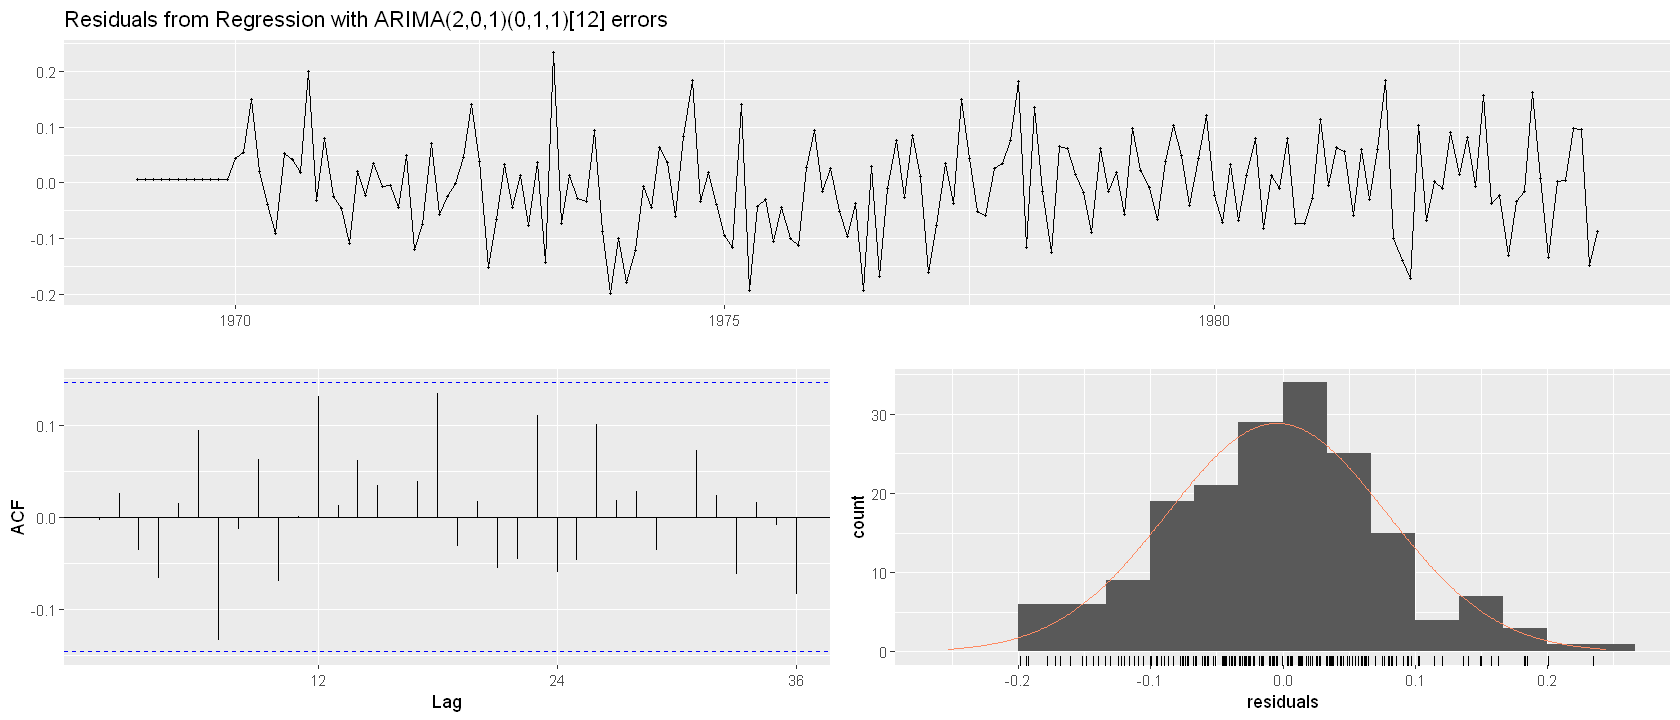

In [49]:
checkresiduals(sarimax_petro_law)

p > 0.05なので有意な自己相関はみられなかった。

## モデルの評価: 残差の正規性

In [50]:
jarque.bera.test(resid(sarimax_petro_law))


	Jarque Bera Test

data:  resid(sarimax_petro_law)
X-squared = 0.39938, df = 2, p-value = 0.819


正規分布と有意に異なっているは言えない、という結果になった。

## ARIMAモデルによる予測

同定されたモデルを使って予測を行う。  
予測にはテストデータを使用する。  
forecastパッケージのforecast関数で予測を行うことができる。

In [51]:
# 説明変数の用意
petro_law_test <- test[, c("PetrolPrice", "law")]

# 予測
sarimax_f <- forecast(
    sarimax_petro_law,
    xreg = petro_law_test,
    h = 12,  # 12点先まで予測する
    level = c(95, 70)  # 95%, 70%予測区間も併せて出力する
)

In [52]:
sarimax_f

         Point Forecast    Lo 70    Hi 70    Lo 95    Hi 95
Jan 1984       6.140922 6.050389 6.231454 5.969719 6.312124
Feb 1984       6.079469 5.986077 6.172861 5.902858 6.256080
Mar 1984       6.167368 6.072965 6.261771 5.988846 6.345890
Apr 1984       6.196306 6.101088 6.291523 6.016243 6.376368
May 1984       6.293745 6.197758 6.389732 6.112227 6.475262
Jun 1984       6.274492 6.177762 6.371222 6.091568 6.457416
Jul 1984       6.394263 6.296812 6.491714 6.209976 6.578550
Aug 1984       6.427685 6.329534 6.525836 6.242075 6.613294
Sep 1984       6.354929 6.256100 6.453759 6.168036 6.541823
Oct 1984       6.396352 6.296863 6.495840 6.208212 6.584491
Nov 1984       6.340966 6.240838 6.441095 6.151616 6.530317
Dec 1984       6.448938 6.348188 6.549689 6.258413 6.639464

Warning message:
"`filter_()` is deprecated as of dplyr 0.7.0.
Please use `filter()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


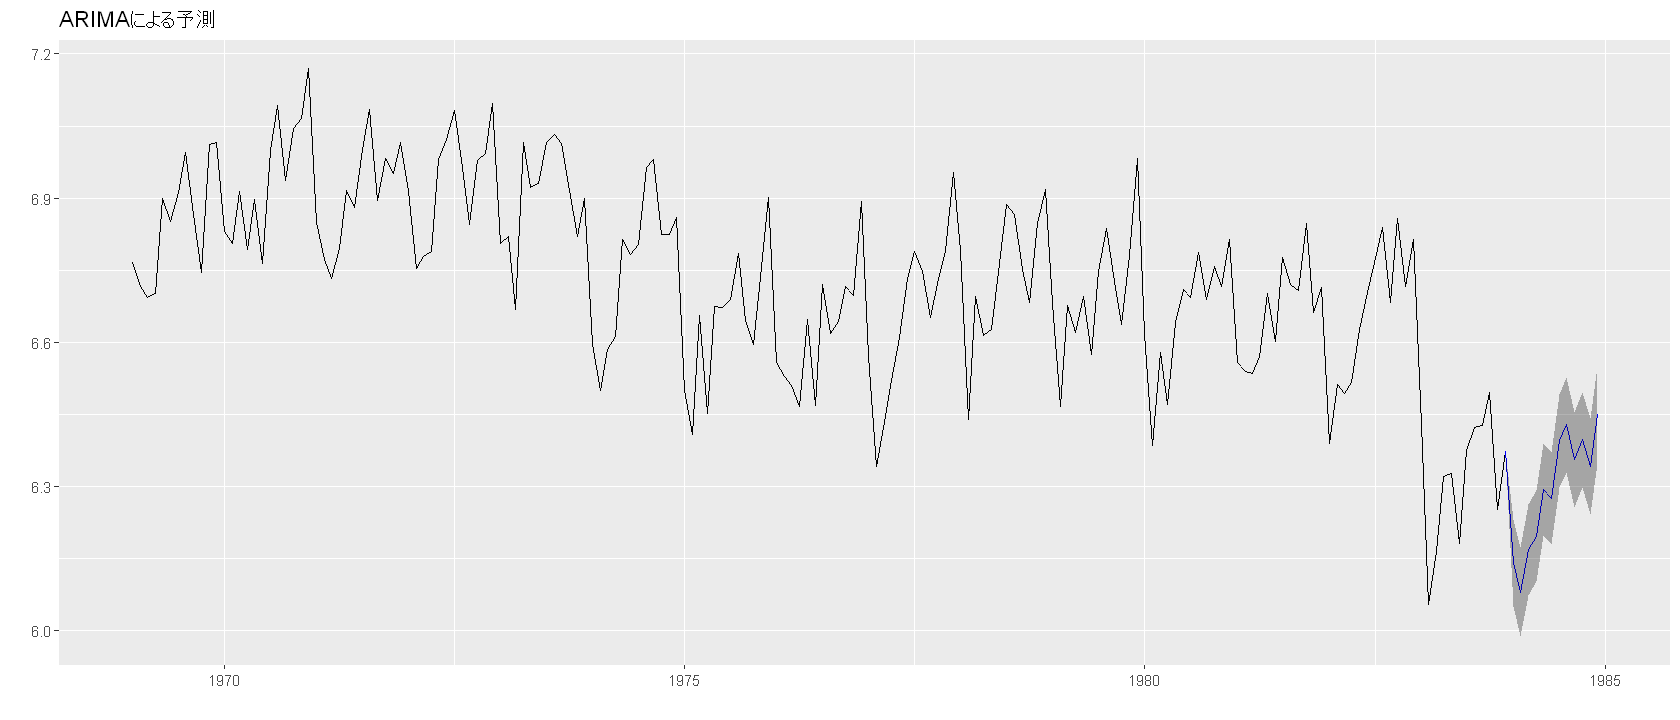

In [53]:
# 予測結果の図示
autoplot(sarimax_f, predict.color=1, main="ARIMAによる予測")

引数に実際の石油価格を使用していると、**「将来の石油価格がわかっている前提で予測を出している」** という状態になっています。  
これはあり得ないので **過去の石油価格の平均値を予測に使って** 予測する。

In [55]:
petro_law_mean <- data.frame(
    PetrolPrice = rep(mean(train[, "PetrolPrice"]), 12),
    law = rep(1, 12)
)

In [58]:
petro_law_mean_mat <- as.matrix(petro_law_mean)

In [61]:
sarimax_f_mean <- forecast(sarimax_petro_law, xreg=petro_law_mean_mat)
sarimax_f_mean

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 1984       6.194413 6.082470 6.306357 6.023211 6.365616
Feb 1984       6.123359 6.007879 6.238839 5.946748 6.299970
Mar 1984       6.214309 6.097580 6.331038 6.035787 6.392831
Apr 1984       6.242017 6.124280 6.359754 6.061955 6.422080
May 1984       6.337695 6.219007 6.456383 6.156177 6.519212
Jun 1984       6.318318 6.198711 6.437926 6.135395 6.501242
Jul 1984       6.438607 6.318108 6.559105 6.254320 6.622894
Aug 1984       6.471575 6.350211 6.592939 6.285965 6.657184
Sep 1984       6.396515 6.274312 6.518718 6.209621 6.583408
Oct 1984       6.445650 6.322632 6.568668 6.257510 6.633789
Nov 1984       6.388848 6.265039 6.512657 6.199498 6.578198
Dec 1984       6.496951 6.372373 6.621529 6.306425 6.687477

直近の石油価格を使った予測値も出してみる

In [63]:
petro_law_tail <- data.frame(
    PetrolPrice = rep(tail(train[, "PetrolPrice"], n=1), 12),
    law = rep(1, 12)
)

petro_law_tail_mat <- as.matrix(petro_law_tail)

sarimax_f_tail <- forecast(sarimax_petro_law, xreg=petro_law_tail_mat)
sarimax_f_tail

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 1984       6.141143 6.029200 6.253086 5.969940 6.312345
Feb 1984       6.070088 5.954609 6.185568 5.893477 6.246699
Mar 1984       6.161038 6.044309 6.277768 5.982516 6.339560
Apr 1984       6.188746 6.071010 6.306483 6.008684 6.368809
May 1984       6.284424 6.165736 6.403112 6.102906 6.465942
Jun 1984       6.265048 6.145440 6.384655 6.082124 6.447971
Jul 1984       6.385336 6.264837 6.505835 6.201049 6.569623
Aug 1984       6.418304 6.296941 6.539668 6.232695 6.603914
Sep 1984       6.343244 6.221041 6.465447 6.156350 6.530137
Oct 1984       6.392379 6.269361 6.515397 6.204239 6.580519
Nov 1984       6.335577 6.211768 6.459387 6.146227 6.524927
Dec 1984       6.443680 6.319102 6.568258 6.253154 6.634206

## ナイーブ予測
1. 過去の平均値を予測値として出す
2. 前時点の値を予測として出す

In [65]:
# 過去の平均値を予測値として出す
naive_f_mean <- meanf(train[, "front"], h=12)
naive_f_mean

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 1984       6.729989 6.468432 6.991546 6.328736 7.131243
Feb 1984       6.729989 6.468432 6.991546 6.328736 7.131243
Mar 1984       6.729989 6.468432 6.991546 6.328736 7.131243
Apr 1984       6.729989 6.468432 6.991546 6.328736 7.131243
May 1984       6.729989 6.468432 6.991546 6.328736 7.131243
Jun 1984       6.729989 6.468432 6.991546 6.328736 7.131243
Jul 1984       6.729989 6.468432 6.991546 6.328736 7.131243
Aug 1984       6.729989 6.468432 6.991546 6.328736 7.131243
Sep 1984       6.729989 6.468432 6.991546 6.328736 7.131243
Oct 1984       6.729989 6.468432 6.991546 6.328736 7.131243
Nov 1984       6.729989 6.468432 6.991546 6.328736 7.131243
Dec 1984       6.729989 6.468432 6.991546 6.328736 7.131243

In [66]:
# 前時点の値を予測値として出す
naive_f_latest <- rwf(train[, "front"], h=12)
naive_f_latest

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 1984       6.371612 6.183035 6.560189 6.083208 6.660015
Feb 1984       6.371612 6.104924 6.638300 5.963748 6.779476
Mar 1984       6.371612 6.044987 6.698237 5.872082 6.871141
Apr 1984       6.371612 5.994458 6.748766 5.794805 6.948419
May 1984       6.371612 5.949941 6.793283 5.726722 7.016502
Jun 1984       6.371612 5.909695 6.833529 5.665170 7.078053
Jul 1984       6.371612 5.872684 6.870539 5.608568 7.134656
Aug 1984       6.371612 5.838236 6.904988 5.555884 7.187340
Sep 1984       6.371612 5.805881 6.937343 5.506401 7.236822
Oct 1984       6.371612 5.775279 6.967944 5.459600 7.283624
Nov 1984       6.371612 5.746173 6.997051 5.415086 7.328138
Dec 1984       6.371612 5.718362 7.024861 5.372553 7.370671

## 予測の評価　RMSE

In [67]:
sarimax_rmse <- sqrt(
     sum((sarimax_f$mean - test[, "front"])^2) / length(sarimax_f$mean)
)

sarimax_rmse

[1] 0.09674572

In [69]:
print(sarimax_f)
print(sarimax_f$mean)

         Point Forecast    Lo 70    Hi 70    Lo 95    Hi 95
Jan 1984       6.140922 6.050389 6.231454 5.969719 6.312124
Feb 1984       6.079469 5.986077 6.172861 5.902858 6.256080
Mar 1984       6.167368 6.072965 6.261771 5.988846 6.345890
Apr 1984       6.196306 6.101088 6.291523 6.016243 6.376368
May 1984       6.293745 6.197758 6.389732 6.112227 6.475262
Jun 1984       6.274492 6.177762 6.371222 6.091568 6.457416
Jul 1984       6.394263 6.296812 6.491714 6.209976 6.578550
Aug 1984       6.427685 6.329534 6.525836 6.242075 6.613294
Sep 1984       6.354929 6.256100 6.453759 6.168036 6.541823
Oct 1984       6.396352 6.296863 6.495840 6.208212 6.584491
Nov 1984       6.340966 6.240838 6.441095 6.151616 6.530317
Dec 1984       6.448938 6.348188 6.549689 6.258413 6.639464
          Jan      Feb      Mar      Apr      May      Jun      Jul      Aug
1984 6.140922 6.079469 6.167368 6.196306 6.293745 6.274492 6.394263 6.427685
          Sep      Oct      Nov      Dec
1984 6.354929 6.396352 6.

In [70]:
# forecastパッケージのaccuracy関数でも確認できる
accuracy(sarimax_f, x=test[, "front"])

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.004353509,0.08283297,0.06430968,-0.07784816,0.9593004,0.5848660,-0.004032101,NA
Test set,0.071495376,0.09674572,0.07537019,1.10793155,1.1703728,0.6854562,0.337639488,1.03686


訓練データのあてはめ精度、テストデータへの予測精度が表示されている。  
RMSEがあてはめ精度よりも予測精度が悪くなっていることに注意する。  
RMSEの差が大きすぎるようだと問題。

In [71]:
# テストデータのRMSEのみを抽出する
accuracy(sarimax_f, x=test[, "front"])["Test set", "RMSE"]

[1] 0.09674572

In [73]:
# 石油価格がわかってないバージョンの予測精度を求める
accuracy(sarimax_f_mean, x=test[, "front"])["Test set", "RMSE"]

# 直近の石油価格での予測精度を求める
accuracy(sarimax_f_tail, x=test[, "front"])["Test set", "RMSE"]

[1] 0.06945114

[1] 0.1018344

In [74]:
# ナイーブ予測のRMSEを求める

# 過去の平均
accuracy(naive_f_mean, x=test[, "front"])["Test set", "RMSE"]

# 直近の値
accuracy(naive_f_latest, x=test[, "front"])["Test set", "RMSE"]

[1] 0.3949872

[1] 0.1498196

平均を参考にしたもの、直近の値を参考にしたものについてナイーブ予測よりもRMSEが小さくなった。  
うまく時系列モデルができたことがわかる。